Processed colors: 100
Processed colors: 200
Processed colors: 300
Processed colors: 400
Processed colors: 500
Processed colors: 600
Processed colors: 700
Processed colors: 800
Processed colors: 900
Processed colors: 1000
Processed colors: 1100
Processed colors: 1200
Processed colors: 1300
Processed colors: 1400
Processed colors: 1500
Processed colors: 1600
Processed colors: 1700
Processed colors: 1800
Processed colors: 1900
Processed colors: 2000
Processed colors: 2100
Processed colors: 2200
Processed colors: 2300
Processed colors: 2400
Processed colors: 2500
Processed colors: 2600
Processed colors: 2700
Processed colors: 2800
Processed colors: 2900
Processed colors: 3000
Processed colors: 3100
Processed colors: 3200
Processed colors: 3300
Processed colors: 3400
Processed colors: 3500
Processed colors: 3600
Processed colors: 3700
Processed colors: 3800
Processed colors: 3900
Processed colors: 4000
Processed colors: 4100
Processed colors: 4200
Processed colors: 4300
Processed colors: 44

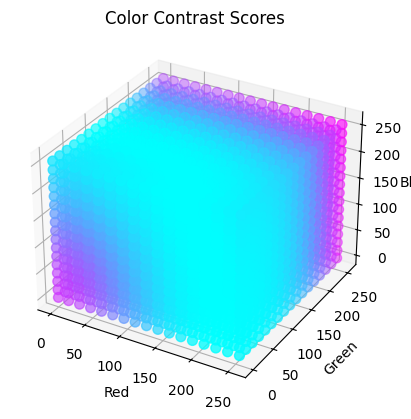

In [2]:
from PIL import Image
from collections import Counter
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
from plotly.subplots import make_subplots



def get_pixels_img(image_path):
    with Image.open(image_path) as img:
        # Resize the image for faster processing if needed
        img = img.resize((50, 50))
        # Get the dimensions of the image
        width, height = img.size
        # Extract pixels from the defined slice
        return list(img.crop((0, height/3, width, height)).getdata())

def get_pixels(image_paths):
    # Get average colors for all images
    return [get_pixels_img(image_path) for image_path in image_paths]

def relative_luminance(rgb):
    # Convert each color component to a fraction of 1
    r, g, b = [x / 255.0 for x in rgb]

    # Apply the sRGB transformation for linearization
    if r <= 0.03928:
        r = r / 12.92
    else:
        r = ((r + 0.055) / 1.055) ** 2.4

    if g <= 0.03928:
        g = g / 12.92
    else:
        g = ((g + 0.055) / 1.055) ** 2.4

    if b <= 0.03928:
        b = b / 12.92
    else:
        b = ((b + 0.055) / 1.055) ** 2.4

    # Calculate the relative luminance
    luminance = 0.2126 * r + 0.7152 * g + 0.0722 * b

    return luminance


def contrast_ratio(p1, p2):
    l1 = relative_luminance(p1)
    l2 = relative_luminance(p2)
    if l1 > l2:
        return (l1 + 0.05) / (l2 + 0.05)
    else:
        return (l2 + 0.05) / (l1 + 0.05)
    
def contrast_list(color, pixels):
    return [contrast_ratio(color, pixel) for pixel in pixels]

def avg_contrast(color, pixels):
    contrasts = contrast_list(color, pixels)
    return sum(contrasts)/len(contrasts)

def avg_contrast_list(color, pixelss):
    contrasts = [avg_contrast(color, pixels) for pixels in pixelss]
    return sum(contrasts)/len(contrasts)

def print_result(cname, color, pixels):
    print(cname + " : ", avg_contrast_list(color, pixels))

""" start = time.time() """
# Replace this with the path to your JPEG images
image_folder = "mappics"

# Get a list of all JPEG files in the folder
image_paths = [
    os.path.join(image_folder, file)
    for file in os.listdir(image_folder)
    if file.lower().endswith((".jpg", ".jpeg"))
]

if not image_paths:
    print("No JPEG images found in the specified folder.")

pixels = get_pixels(image_paths)

""" colors=[(255,255,255),(0,255,255),(255,0,255),(255,255,0),(0,0,255),(255,0,0),(0,255,0),(0,0,0)]
color_names = ["White", "Cyan", "Pink", "Yellow", "Blue", "Red", "Lime", "Black"]
for i in range(len(color_names)):
    print_result(color_names[i], colors[i], pixels) """

colors = []
step = 16
start = -1
for i in range(start, 256, step):
    for j in range(start, 256, step):
        for k in range(start, 256, step):
            if (i == -1): i = 0
            if (j == -1): j = 0
            if (k == -1): k = 0
            colors.append((i, j, k))


scores = []
progress_counter = 0
for color in colors:
    scores.append((color, avg_contrast_list(color, pixels)))
    progress_counter += 1
    if (progress_counter % 100) == 0:
        print("Processed colors:", progress_counter)

sorted_scores = sorted(scores, key=lambda x: x[1])
for i in range(1, 20):
    print(sorted_scores[-i])

""" end = time.time()
elapsed_time = (end - start)
print(f"Elapsed time: {elapsed_time}")
print("Elapsed time (rounded):", round(elapsed_time)) """
    
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extract RGB values and scores for plotting
r_values = [color[0] for color, _ in scores]
g_values = [color[1] for color, _ in scores]
b_values = [color[2] for color, _ in scores]
scores_values = [score for _, score in scores]

# Plot the data
ax.scatter(r_values, g_values, b_values, c=scores_values, cmap='cool', s=50)

# Add labels
ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')
ax.set_title('Color Contrast Scores')

# Show the plot
plt.show() 


In [6]:
# Plot the data using Plotly
fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scatter3d'}]])
scatter = go.Scatter3d(
    x=r_values,
    y=g_values,
    z=b_values,
    mode='markers',
    marker=dict(
        size=15,
        color=scores_values,
        colorscale="Plasma",
        opacity=1
    )
    
)
fig.add_trace(scatter)

# Set layout
fig.update_layout(
    scene=dict(
        xaxis=dict(title='Red'),
        yaxis=dict(title='Green'),
        zaxis=dict(title='Blue')
    ),
    title='Color Contrast Scores',
    margin=dict(l=0, r=0, b=0, t=0)
)

# Save the figure as an interactive HTML file
fig.write_html('color_contrast_scores_interactive.html')